# El modelo epidémico de SIR

**Realizado por:**
Juan Carlos Benavides Cabrera.

Una descripción matemática simple de la propagación de una enfermedad en una población es el llamado modelo SIR, que divide la población (fija) de N individuos en tres "compartimentos" que pueden variar en función del tiempo, t:

* S(t) son aquellos susceptibles pero aún no infectados con la enfermedad;
* I(t) es el número de individuos infecciosos;
* R(t) son aquellas personas que se han recuperado de la enfermedad y ahora tienen inmunidad.

El modelo SIR describe el cambio en la población de cada uno de estos compartimentos en términos de dos parámetros,  beta y  gamma.  
- Beta describe la tasa de contacto efectiva de la enfermedad: un individuo infectado entra en contacto con  beta*N otros individuos por unidad de tiempo (de los cuales la fracción que es susceptible a contraer la enfermedad es S/N).  
- Gamma es la tasa de recuperación promedio: es decir, 1/ gamma es el período de tiempo promedio durante el cual una persona infectada puede transmitirlo.

Las ecuaciones diferenciales que describen este modelo fueron derivadas primero por Kermack y McKendrick [ Proc. R. Soc. A , 115 , 772 (1927)]:

\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\frac{\beta S I}{N},\\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \frac{\beta S I}{N} - \gamma I,\\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I.
\end{align*}

El siguiente código de Python integra estas ecuaciones para una enfermedad caracterizada por los parámetros  beta=0.2, gamma=10  en una población de N=1000 (quizás 'gripe en una escuela ) El modelo se inicia con una sola persona infectada el día 0: I(0)=1. Las curvas trazadas de S(t), I(t) y R(t) están diseñadas para verse un poco mejor que los valores predeterminados de Matplotlib.

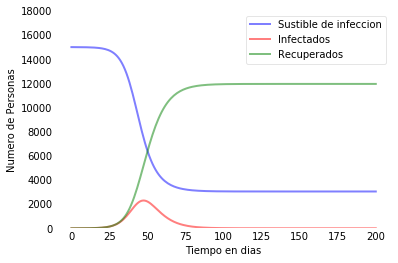

In [29]:
#Importar las librerias.
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total de la poblacion
N = 15000
# Numero Inicial de Infectados
I0 = 1
# Numero de Recuperados
R0 = 0
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0
# Tasa de contacto, beta (nivel de repoductividad del virus) 
# La tasa de recuperación media, gamma,(1/días) Una persona se recupera en 15 dias.
beta, gamma = 0.4, 1.0/5 
# Una cuadrícula de puntos de tiempo (en días)
t = np.linspace(0, 200, 200)


# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

#Ro = beta/gamma
#print(Ro)


## Generar la prediccion del modelos SIR

 Se debe  estimar el valor de 
- β 
- γ

Para ajustar el modelo SIR con los casos confirmados reales (el número de personas infecciosas) del Ecuador.
 
 Para ello deben seguir el siguiente tutorial 
 https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
 


In [1]:
# Implementar librerias 
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from time import time
import argparse
import sys
import json
import ssl
import urllib.request

In [2]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df= pd.read_csv(url)
df = df[df['Country/Region'] == 'Ecuador'].iloc[0].loc[:]
df

Province/State        NaN
Country/Region    Ecuador
Lat               -1.8312
Long             -78.1834
1/22/20                 0
                   ...   
4/10/20              7161
4/11/20              7257
4/12/20              7466
4/13/20              7529
4/14/20              7603
Name: 97, Length: 88, dtype: object

S: 7387 	I: 7603 	R: 10
β: 0.4
γ: 0.4


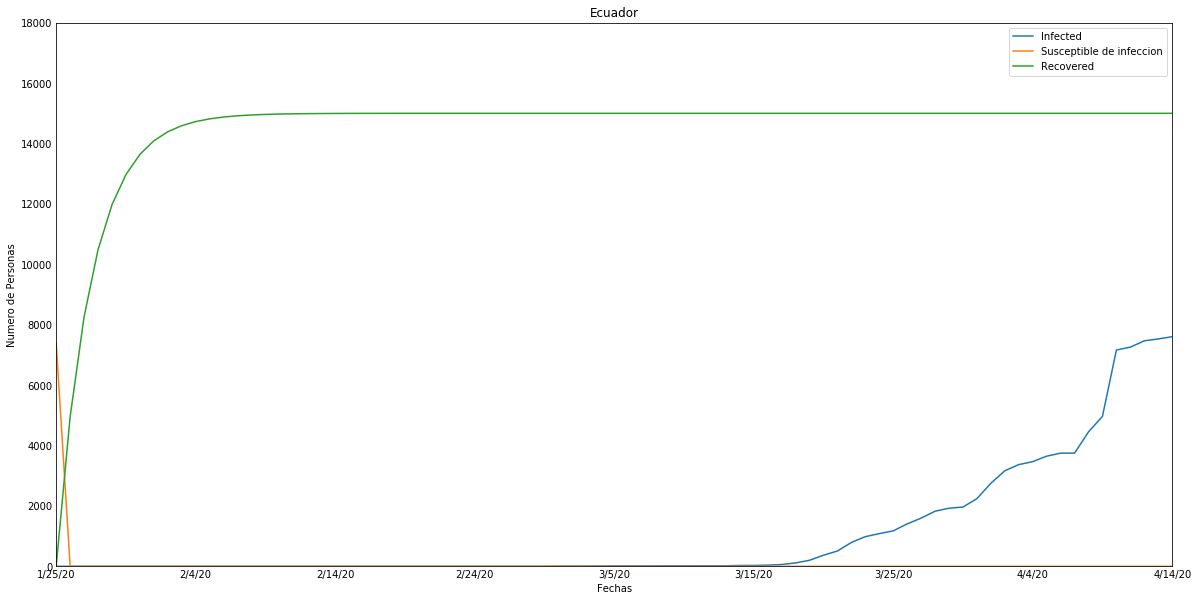

In [20]:
class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.Beta = 0
        self.Gamma = 0
        
        
    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:] 
    
    
    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values
    
    def predict(self, beta, gamma, data, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))
    
    
    def train(self):
            data = (self.load_confirmed(self.country))
            self.i0=data[-1]
            optimal = minimize(loss,
                               [0.001, 0.001],
                               args=(data, self.s_0, self.i_0, self.r_0),
                               method='L-BFGS-B',
                               bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
            beta, gamma = optimal.x
            self.Beta, self.Gamma = optimal.x
            new_index, extended_actual, prediction = self.predict(beta, gamma, data, self.country, self.s_0, self.i_0, self.r_0)
            df = pd.DataFrame({'Infected': extended_actual,
                               'Susceptible de infeccion': prediction.y[0], 
                               'Recovered': prediction.y[2]},
                              index=new_index)
            
            fig, ax = plt.subplots(figsize=(20, 10))
            ax.set_ylim(0,N*1.2)
            ax.yaxis.set_tick_params(length=0)
            ax.xaxis.set_tick_params(length=0)
            ax.set_xlabel('Fechas')
            ax.set_ylabel('Numero de Personas')
            ax.set_title(self.country)
            
            df.plot(ax=ax)
            print("β: "+str(beta))
            print("γ: "+str(gamma))
            
            
def loss(point, data, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=False)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

N=15000
i0=df[-1]
r0=10
s0=N - i0 - r0
print('S:',s0,'\tI:',i0,'\tR:',r0)
learner = Learner('Ecuador', loss, '1/25/20', 10, s0, i0, r0)
learner.train()


S: 9898 	I: 1 	R: 0
β: 1.2974360658194054e-05
γ: 0.005368789159044693


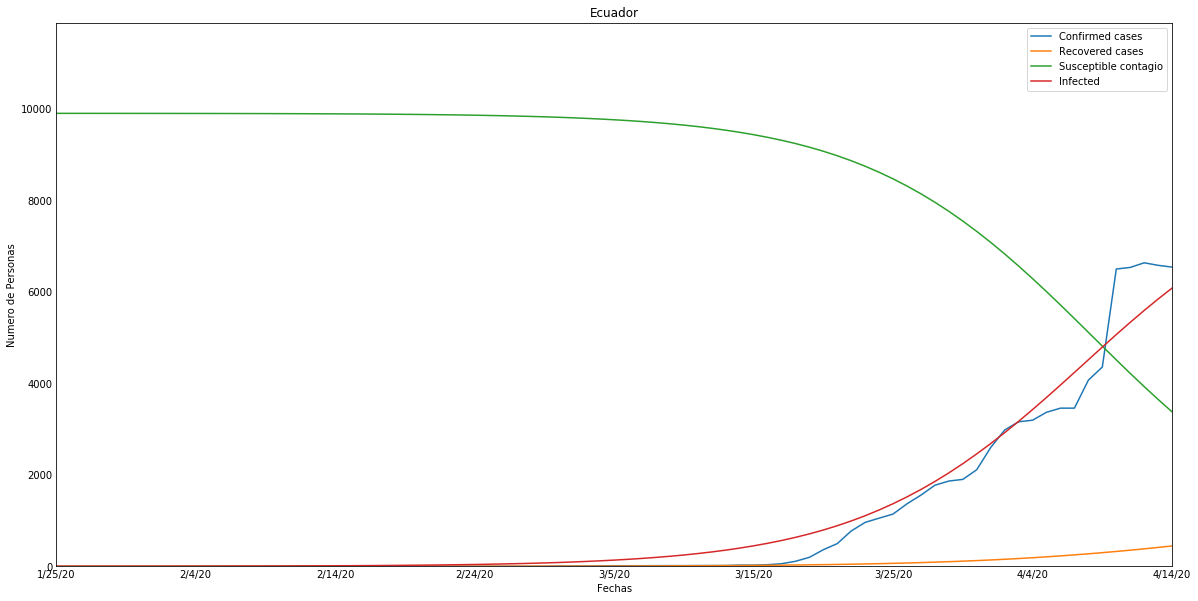

In [29]:
class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.Beta = 0
        self.Gamma = 0

    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

    def load_death(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    
    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        current = current + timedelta(days=9)
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values,
                                          [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values,
                                             [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values,
                                         [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_death(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(loss, [0.001, 0.001],
                           args=(data,
                                 recovered,
                                 self.s_0,
                                 self.i_0,
                                 self.r_0),
                           method='L-BFGS-B',
                           bounds=[(0.00000001, 0.7529), (0.00000001, 0.544)])
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Confirmed cases': extended_actual,
                           'Recovered cases': extended_recovered,
                           'Susceptible contagio': prediction.y[0],
                           'Infected': prediction.y[1],
                           'Recovered cases': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlabel('Fechas')
        ax.set_ylabel('Numero de Personas')
        ax.set_ylim(0,N*1.2)
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.set_title(self.country)
        df.plot(ax=ax)
        print("β: "+str(beta))
        print("γ: "+str(gamma))


def loss(point, data, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

N=9899
i0=1
r0=0
s0=N - i0 - r0
print('S:',s0,'\tI:',i0,'\tR:',r0)

learner = Learner('Ecuador', loss, '1/25/20', 10, s0, i0, r0)
learner.train()
    

In [54]:
poblacion = 17023000
#nuevos en 10 dias 7603-3645
nuevos=3958
#10*24horas=240
tiempo=240

def incidencia(new_cases,riesgo,tiempo):
    return (new_cases/riesgo)*pow(10,tiempo)
print("incidencia: "+str(incidencia(nuevos,poblacion,tiempo)))

#casos positivos a la fecha
positivos=7603
#tiempo desde el primercaso 46*24
tiempopc=1080
def prevalencia(casosP, poblacion, tiempo):
    return (casosP/poblacion)*pow(10, tiempo)

from decimal import Decimal

#prevalenciar = Decimal((prevalencia(positivos,poblacion,tiempopc)))
print("prevalencia: "+str(prevalencia(positivos,poblacion,5)))



incidencia: 2.325089584679551e+236
prevalencia: 44.66310286083534


## Analisis
Gracias al modelo matemático SIR he comprobado características sobre el brote epidemiológico que está atravesando el país con el COVID-19 y a la vez realizar predicciones, lo que intentan los países es intentar aplanar la curva y frenar los contagios. El modelo relaciona las variaciones las tres poblaciones (Susceptible, Infectada y Recuperada).

## Conclusiones
Según el modelo matemático y los datos presentados por la OMS, la población susceptible ha disminuido, pero eso no descarta la gran cantidad de contagios y muertes que está sufriendo el país como consecuencia de que el estado no tomo cartas al asunto enseguida por elevar medidas. El primer mandatario del país Lenin Moreno, ha dicho que las cifras podrían no ser reales, como es bastante evidente, así que la curva podría ser más elevada.

## Opinion
"No pasa nada"

"Por nuestras culturas somos muy resistentes a todas las calamidades"

"No dejen de salir, todavía estamos en la primera fase"

"Es un invento de los conservadores"

"No debemos asustarnos"


A lo largo de dos meses he escuchado y leído con frecuencia las dichas frases, aunque cada vez con menos frecuencia; lo cual me llevo a pensar


¿Es Ecuador un país tercermundista y miserable?

Planteare dos extremos: ¿Es el ecuatoriano vivaracho, que goza de la “viveza criolla, que es más avispado que el resto? o ¿El ecuatoriano es astuto y emotivo que nunca para y encuentra la forma beneficiarse y salir adelante? La respuesta podría ser las dos, aunque no completamente, pero voy a optar por la más visible y es el pensamiento tercermundista, que nos ha demostrado que somos un pueblo incapaz de organizarse y generar estupidez colectiva.


También tiene que ver la estructura del país, ya que está demostrado que Ecuador ha dejado mucho que desear económicamente frente a esta emergencia sanitaria más que todo por el colapso de los sistemas; y políticamente nefasto ya que el primer mandatario prefirió anunciar las nuevas medidas económicas antes que hacer frente a la emergencia mundial y cuidar de su pueblo, el cual al día de hoy no hace presencia  y toma medidas o "patadas de ahogado" para disimular la mala gestión.


No voy a descartar el caso de que existen ciudadanos que viven del día y de ello depende si alimentan a su familia, quienes llegan a exponerse ya que es la única manera de intentar sobrevivir a esta crisis.






# Referencias:
- https://www.agenciasinc.es/Reportajes/Un-modelo-un-teorema-y-teoria-de-juegos-contra-el-coronavirus
- https://rpubs.com/dsfernandez/422937
- https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
- https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases